In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from glob import glob

In [20]:
path = "../data/train/binary"
files = glob(f"{path}/*.csv.gz")
df_list = [pd.read_csv(f) for f in files]
train_data = pd.concat(df_list, ignore_index=True)
# train_data = train_data[train_data["Label"] == 0]
print(train_data.shape)
feature_cols = [c for c in train_data.columns if c != 'Label']
scaler = MinMaxScaler()
train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])

label_values_counts = len(train_data["Label"].unique())

classes = train_data.columns
classes = classes.drop('Label')
with open('feature_names.csv', 'w') as f:
    for i, c in enumerate(classes):
        f.write(f"{i},{c}\n")

# train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Label"])

(1469979, 89)


In [4]:
class DataFrameDataset(Dataset):
    def __init__(self, df, target_column):
        self.features = df.drop(columns=[target_column]).values.astype(np.float32)
        self.labels = df[target_column].values.astype(np.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx])
        if self.labels is not None:
            y = torch.tensor(self.labels[idx])
            return x, y
        else:
            return x


BATCH_SIZE = 500
train_dataset = DataFrameDataset(train_data, target_column='Label')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
# BATCH_SIZE = 16

# train_data = MNIST("./test_data", 
#                    train=True, 
#                    download=True, 
#                    transform=transforms.ToTensor())

# train_loader = DataLoader(train_data,
#                           batch_size=BATCH_SIZE,
#                           shuffle=True)
# print("train data size: ",len(train_data))   #train data size:  60000
# print("train iteration number: ",len(train_data)//BATCH_SIZE)   #train iteration number:  3750


In [6]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([16, 1, 28, 28])
print("label:",labels)   #label: tensor([7, 3, 0, 3, 7, 2, 5, 3, 2, 0, 8, 7, 4, 9, 5, 7])

# image_numpy = images.detach().numpy().copy()
# plt.imshow(image_numpy[0,0,:,:], cmap='gray')


images_size: torch.Size([500, 88])
label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 4, 0, 0, 7, 0, 0, 0, 0, 3, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 7, 0, 2, 0, 0, 0, 0, 7, 0, 0,
        0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 3, 0, 6, 0, 3, 0, 0, 0, 0, 0, 7, 0, 0,
        0, 6, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 2, 3, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 7, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 7, 0, 3, 0, 2, 3, 0, 0,
        0, 0, 2, 0, 0, 3, 0, 2, 0, 0, 7, 0, 0, 0, 0, 2, 3, 0, 7, 0, 3, 0, 0, 4,
        0, 0, 0, 3, 2, 0, 3, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0,
        0, 0, 0, 0, 0, 3, 0, 8, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 6, 0, 0, 0, 6,
        0, 7, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 7

In [7]:
class MLPGenerator(nn.Module):
    def __init__(self, z_dim, n_labels, out_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + n_labels, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.Sigmoid(),  # 0-1の範囲に収める
        )
    
    def forward(self, z, y, forced_output: torch.Tensor = None):
        if forced_output is not None:
            fo = forced_output.to(z.device).float()
            if fo.dim() == 1:
                fo = fo.unsqueeze(0).expand(z.size(0), -1)
            return fo
        y_hot = F.one_hot(
            y.long(), num_classes=y.max().item() + 1
        ).to(z.device)
        inp = torch.cat([z, y_hot], dim=1)
        return self.net(inp)


class MLPDiscriminator(nn.Module):
    def __init__(self, in_dim, n_labels, embed_dim=64, hidden_dim=256):
        super().__init__()
        self.label_emb = nn.Embedding(n_labels, embed_dim)
        self.net = nn.Sequential(
            nn.Linear(in_dim + embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        y_emb = self.label_emb(y)
        inp = torch.cat([x, y_emb], dim=1)
        return self.net(inp)

In [8]:
# class TwoConvBlock_2D(nn.Module):
#   def __init__(self, in_channels, out_channels):
#     super().__init__()
#     self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding="same")
#     self.bn1 = nn.BatchNorm2d(out_channels)
#     self.rl = nn.LeakyReLU()
#     self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding="same")
#     self.bn2 = nn.BatchNorm2d(out_channels)

#   def forward(self, x):
#     x = self.conv1(x)
#     x = self.bn1(x)
#     x = self.rl(x)
#     x = self.conv2(x)
#     x = self.bn2(x)
#     x = self.rl(x)
#     return x

# class Discriminator(nn.Module):   #識別器
#   def __init__(self):
#     super().__init__()
#     self.conv1 = TwoConvBlock_2D(1,64)
#     self.conv2 = TwoConvBlock_2D(64, 128)
#     self.conv3 = TwoConvBlock_2D(128, 256)

#     self.avgpool_2D = nn.AvgPool2d(2, stride = 2)
#     self.global_avgpool_2D = nn.AvgPool2d(7)

#     self.l1 = nn.Linear(256, 20)
#     self.l2 = nn.Linear(20, 1)
#     self.rl = nn.LeakyReLU()
#     self.dropout1 = nn.Dropout(0.5)
#     self.dropout2 = nn.Dropout(0.1)
#     self.embed = nn.Embedding(10, 256)

#   def forward(self, x, y):
#     x = self.conv1(x)
#     x = self.avgpool_2D(x)
#     x = self.conv2(x)
#     x = self.avgpool_2D(x)
#     x = self.conv3(x)
#     x = self.global_avgpool_2D(x)
#     x = x.view(-1, 256)
#     _x = x
#     x = self.dropout1(x)
#     x = self.l1(x)
#     x = self.rl(x)
#     x = self.dropout2(x)
#     x = self.l2(x)

#     _y = self.embed(y)   #ラベルをembedding層で埋め込む
#     xy = (_x*_y).sum(1, keepdim=True)   #出力ベクトルとの内積をとる

#     x = x+xy   #内積を加算する
#     x = torch.sigmoid(x)
#     return x

# class Generator(nn.Module):   #生成器
#   def __init__(self):
#     super().__init__()
#     self.l = nn.Linear(110, 49)
#     self.dropout = nn.Dropout(0.2)
#     self.TCB1 = TwoConvBlock_2D(1,512)
#     self.TCB2 = TwoConvBlock_2D(512,256)
#     self.TCB3 = TwoConvBlock_2D(256,128)
#     self.UC1 = nn.ConvTranspose2d(512, 512, kernel_size =2, stride = 2)
#     self.UC2 = nn.ConvTranspose2d(256, 256, kernel_size =2, stride = 2)
#     self.conv1 = nn.Conv2d(128, 1, kernel_size = 2, padding="same")
  

#   def forward(self, x, y):
#     y = torch.nn.functional.one_hot(y.long(), num_classes=10).to(torch.float32)
#     x = torch.cat([x, y], dim= 1)
#     x = self.dropout(x)
#     x = self.l(x)
#     x = torch.reshape(x, (-1, 1, 7, 7))
#     x = self.TCB1(x)
#     x = self.UC1(x)
#     x = self.TCB2(x)
#     x = self.UC2(x)
#     x = self.TCB3(x)
#     x = self.conv1(x)
#     x = torch.sigmoid(x)
#     return x


In [9]:
def get_device_name():
    if torch.cuda.is_available():
        return "cuda:0"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

In [11]:
device = torch.device(get_device_name())   #GPUを設定
# model_D = Discriminator().to(device)
# model_G = Generator().to(device)
model_D = MLPDiscriminator(in_dim=len(feature_cols), n_labels=label_values_counts).to(device)
model_G = MLPGenerator(z_dim=100, n_labels=label_values_counts, out_dim=len(feature_cols)).to(device)

true_labels = torch.ones(BATCH_SIZE).reshape(BATCH_SIZE, 1).to(device)   #1のラベル
fake_labels = torch.zeros(BATCH_SIZE).reshape(BATCH_SIZE, 1).to(device)   #0のラベル

criterion = nn.BCELoss()    #損失関数はBCE(Binary Cross Entropy)を使用

optimizer_D = optim.Adam(model_D.parameters(), lr=0.00001)   #最適化関数はAdamを使用
optimizer_G = optim.Adam(model_G.parameters(), lr=0.00001)

epoch_num = 10   #エポック数（同じデータセットを何回学習するか）
print_coef = 10
G_train_ratio = 2   #識別器の学習1回あたり生成器が学習する回数
train_length = len(train_data)

def calc_acc(pred):   #正解率の評価関数
  pred = torch.where(pred > 0.5, 1., 0.)
  acc = pred.sum()/pred.size()[0]
  return acc

history = {"loss_D": [], "loss_G": [], "acc_true": [], "acc_fake": []}
n = 0
m = 0

for epoch in range(epoch_num):
  train_loss_D = 0
  train_loss_G = 0
  train_acc_true = 0
  train_acc_fake = 0

  model_D.train()
  model_G.train()
  for i, data in enumerate(train_loader):
    optimizer_D.zero_grad()
    inputs, labels = data[0].to(device), data[1].to(device)

    #識別器の学習（1）
    outputs = model_D(inputs, labels)   #本物の画像が本物か偽物か判定
    output_true_labels = torch.ones((outputs.size(0), 1), device=device)  # Adjust size to match outputs
    loss_true = criterion(outputs, output_true_labels)   #本物のデータを本物と判定するように学習したいので1のラベルを使用
    acc_true = calc_acc(outputs)

    #識別器の学習（2）
    noise = torch.randn((BATCH_SIZE, 100), dtype=torch.float32).to(device)   #ランダムな配列を生成
    noise_label = torch.from_numpy(np.random.randint(0,10,BATCH_SIZE)).clone().to(device)   #1~9のランダムな整数を生成
    inputs_fake = model_G(noise, noise_label).to(device)   #偽物の画像を生成
    outputs_fake = model_D(inputs_fake.detach(), noise_label)   #偽物の画像が本物か偽物か判定
    loss_fake = criterion(outputs_fake, fake_labels)   #偽物の画像を偽物と判定する方向に学習したいので0のラベルを使用
    acc_fake = calc_acc(outputs_fake)
    loss_D = loss_true + loss_fake   #識別器の学習（1）・（2）の損失を足し合わせる
    loss_D.backward()
    optimizer_D.step()   #識別器のパラメータを更新する

    #生成器の学習
    for _ in range(G_train_ratio):   #G_train_ratioの回数分生成器の学習を繰り返す
      optimizer_G.zero_grad()
      noise = torch.randn((BATCH_SIZE, 100), dtype=torch.float32).to(device)  #ランダムな配列を生成
      noise_label = torch.from_numpy(np.random.randint(0,10,BATCH_SIZE)).clone().to(device)   #1~9のランダムな整数を生成
      inputs_fake = model_G(noise, noise_label).to(device)
      outputs_fake = model_D(inputs_fake, noise_label)
      loss_G = criterion(outputs_fake, true_labels)   #本物と判定される偽物の画像を生成したいので1のラベルを使用
      loss_G.backward()
      optimizer_G.step()   #生成器のパラメータを更新する

    #学習経過の保存
    train_loss_D += loss_D.item()
    train_loss_G += loss_G.item()
    train_acc_true += acc_true.item()
    train_acc_fake += acc_fake.item()
    n += 1
    history["loss_D"].append(loss_D.item())
    history["loss_G"].append(loss_G.item())
    history["acc_true"].append(acc_true.item())
    history["acc_fake"].append(acc_fake.item())

    if i % ((train_length//BATCH_SIZE)//print_coef) == (train_length//BATCH_SIZE)//print_coef - 1:
      print(f"epoch:{epoch+1:3d}  index:{i+1:5d}  loss_D:{train_loss_D/n:.10f}  loss_G:{train_loss_G/n:.10f}  acc_true:{train_acc_true/n:.10f}  acc_fake:{train_acc_fake/n:.10f}")

      n = 0
      train_loss_D = 0
      train_loss_G = 0
      train_acc_true = 0
      train_acc_fake = 0

print("finish training")


epoch:  1  index:  293  loss_D:1.1920668066  loss_G:0.7567558714  acc_true:0.9108055020  acc_fake:0.2220750958
epoch:  1  index:  586  loss_D:0.9420546619  loss_G:0.9122255192  acc_true:0.7866007187  acc_fake:0.0998771375
epoch:  1  index:  879  loss_D:0.8257540619  loss_G:1.1520606147  acc_true:0.7592560079  acc_fake:0.1009078545
epoch:  1  index: 1172  loss_D:0.7538835258  loss_G:1.4925397447  acc_true:0.7601092490  acc_fake:0.0997201411
epoch:  1  index: 1465  loss_D:0.7034999358  loss_G:1.7937135818  acc_true:0.7636723907  acc_fake:0.0996450558
epoch:  1  index: 1758  loss_D:0.6709832616  loss_G:2.1030444464  acc_true:0.7820955999  acc_fake:0.1005460795
epoch:  1  index: 2051  loss_D:0.6380032165  loss_G:2.3977682420  acc_true:0.8428669348  acc_fake:0.1009078542
epoch:  1  index: 2344  loss_D:0.6228059599  loss_G:2.5779484425  acc_true:0.8493242713  acc_fake:0.1018634858
epoch:  1  index: 2637  loss_D:0.5734247669  loss_G:2.8146181432  acc_true:0.8771263206  acc_fake:0.0999317451
e

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x701cb6f2b1f0>>
Traceback (most recent call last):
  File "/home/ishibashi02/research_data_drl/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 796, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
  File "/home/ishibashi02/.local/share/uv/python/cpython-3.10.18-linux-x86_64-gnu/lib/python3.10/threading.py", line 1487, in enumerate
    return list(_active.values()) + list(_limbo.values())
KeyboardInterrupt: 


epoch:  3  index: 1758  loss_D:0.5998682468  loss_G:4.3224663987  acc_true:0.7410990101  acc_fake:0.1209078552
epoch:  3  index: 2051  loss_D:0.5131435282  loss_G:4.3667194908  acc_true:0.7773925263  acc_fake:0.0374129711
epoch:  3  index: 2344  loss_D:0.4749977649  loss_G:4.5312238862  acc_true:0.8144573763  acc_fake:0.0097337888
epoch:  3  index: 2637  loss_D:0.5502113855  loss_G:4.4937748225  acc_true:0.7493583979  acc_fake:0.0636723576
epoch:  3  index: 2930  loss_D:0.4842476864  loss_G:4.6231520119  acc_true:0.8071263170  acc_fake:0.0089556318
epoch:  4  index:  293  loss_D:0.4897128735  loss_G:4.4288081493  acc_true:0.7536832033  acc_fake:0.0051287131
epoch:  4  index:  586  loss_D:0.5322556454  loss_G:4.5254845391  acc_true:0.7519863838  acc_fake:0.0327781584
epoch:  4  index:  879  loss_D:0.4860983418  loss_G:4.6735623330  acc_true:0.7815358732  acc_fake:0.0206075095
epoch:  4  index: 1172  loss_D:0.4910037588  loss_G:4.7201324063  acc_true:0.7860068630  acc_fake:0.0087918093
e

Text(0, 0.5, 'loss_G')

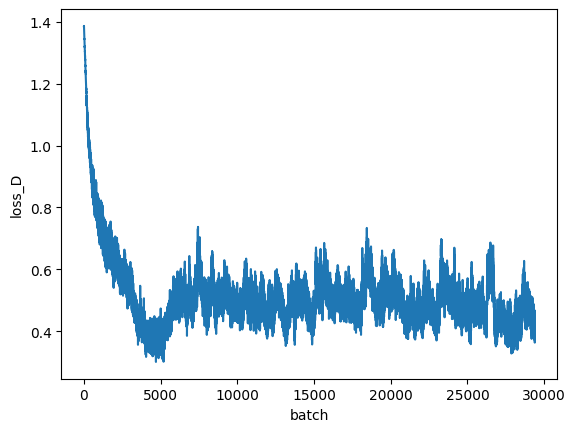

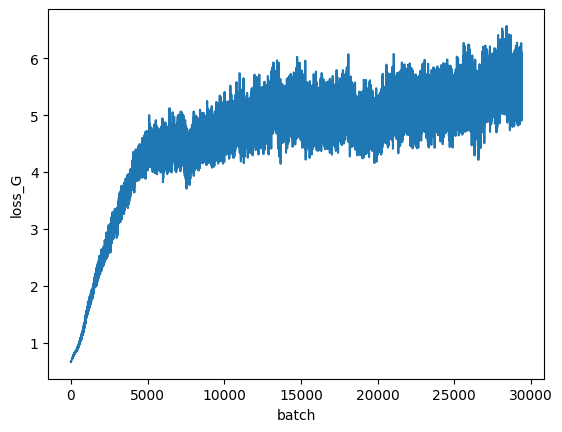

In [12]:
plt.figure()
plt.plot(history["loss_D"])
plt.xlabel('batch')
plt.ylabel('loss_D')

plt.figure()
plt.plot(history["loss_G"])
plt.xlabel('batch')
plt.ylabel('loss_G')


In [22]:
for i in range(10):
  intnp = np.random.randint(i ,i + 1 ,10)
  if i == 0:
    label_np = intnp
  else:
    label_np = np.concatenate([label_np, intnp], 0)

model_G.to("cpu")
with torch.no_grad():
  noise = torch.randn((100, 100), dtype=torch.float32)
  noise_label = torch.from_numpy(label_np).clone()
  syn_data = model_G(noise, noise_label)

sample = syn_data.detach().numpy().copy()

with open("generate_data.csv", "w") as f:
  class_row = ",".join(map(str, classes))
  f.write(f"index,{class_row}\n")

  for row in range(len(sample)):
    data_join = ",".join(map(str, sample[row]))
    f.write(f"{row},{data_join}\n")
